## Cataract Detection Models

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path



2024-10-12 09:33:59.198785: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-12 09:33:59.199448: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-12 09:33:59.201882: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-12 09:33:59.208677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 09:33:59.219410: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

### Load dataset

In [4]:
dataset_path = '../dataset'

cataract = Path(dataset_path + '/cataract')
normal = Path(dataset_path + '/normal')

In [17]:
from tqdm import tqdm

disease_type = [cataract, normal]

df = pd.DataFrame()

for types in disease_type:
    for image_path in tqdm(list(types.iterdir()), desc=str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(image_path)], 'disease_type': [disease_type.index(types)]})],
                       ignore_index=True)

../dataset/normal: 100%|██████████| 1074/1074 [00:00<00:00, 5970.48it/s]


In [7]:
df.head(4)

,image,disease_type
0,../dataset/cataract/2190_right.jpg,0
1,../dataset/cataract/_212_7340392.jpg,0
2,../dataset/cataract/_32_9153320.jpg,0
3,../dataset/cataract/_224_4070697.jpg,0


In [9]:
df.disease_type.value_counts()

disease_type
1    1074
0    1038
Name: count, dtype: int64

### Visualizing images in Dataset

In [26]:
def plot_image(n, num_samples=3):
    disease_labels = ['cataract', 'normal']
    images = df[df['disease_type'] == n].sample(n=num_samples)['image']

    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[n])

    # plt.savefig(f'../assets/{disease_labels[n]}.png')
    plt.show()

In [43]:
plot_image(0)

ValueError: a must be greater than 0 unless no samples are taken

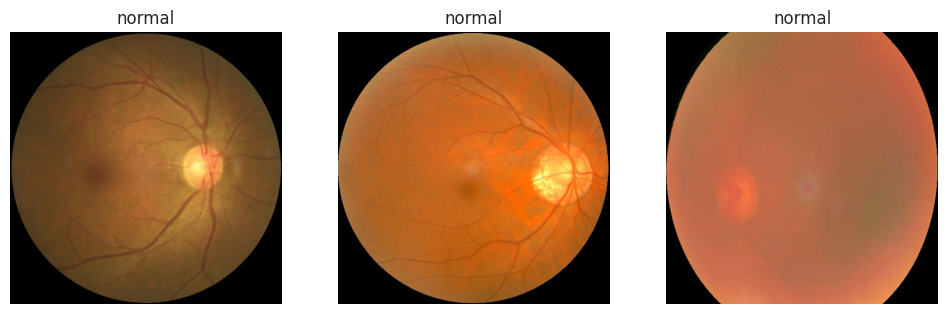

In [13]:
plot_image(1)

In [20]:
df['disease_type'] = df['disease_type'].map({0: 'cataract', 1: 'normal'})
df.disease_type.value_counts()

disease_type
normal      1074
cataract    1038
Name: count, dtype: int64

In [22]:
# shuffling data rpws
df1 = df.sample(frac=1).reset_index(drop=True)

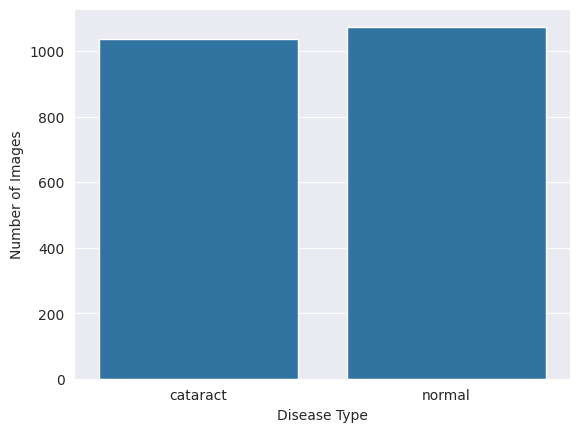

In [25]:
sns.countplot(x='disease_type', data=df1)
plt.xlabel('Disease Type')
plt.ylabel('Number of Images')

plt.savefig('../assets/countplot.png')
plt.show()

In [37]:
from keras import Model, Sequential
from keras.src.optimizers import Adam
from keras.src.layers import Flatten, Dense, MaxPooling2D, Activation, Input, concatenate, Conv2D, Conv2DTranspose
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.src.applications.resnet import preprocess_input

### Data training and Testing

In [38]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2, rescale=1. / 255.)

In [40]:
data_train = datagen.flow_from_dataframe(dataframe=df1,
                                         x_col='image',
                                         y_col='disease_type',
                                         target_size=(224, 224),
                                         class_mode='categorical',
                                         batch_size=32,
                                         shuffle=True,
                                         subset='training')

Found 1690 validated image filenames belonging to 2 classes.


In [41]:
# Data generators for validation
valid_data=datagen.flow_from_dataframe(dataframe=df1,
                                      x_col='image',
                                      y_col = 'disease_type',
                                      target_size = (224,224),
                                      class_mode= 'categorical',
                                      batch_size = 32,
                                      shuffle = False,
                                      subset= 'validation')

Found 422 validated image filenames belonging to 2 classes.


## Building The Model

Model1: VGG19

In [47]:
from keras.src.applications.vgg19 import VGG19

vgg_model = Sequential()
vgg_base = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

vgg_model.add(vgg_base)
vgg_model.add(Flatten())
vgg_model.add(Dense(2, activation="sigmoid"))
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

vgg_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │        50,178 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,074,562 (76.58 MB)

 Trainable params: 20,074,562 (76.58 MB)

 Non-trainable params: 0 (0.00 B)

### Train VGG19

In [48]:
vgg_history = vgg_model.fit(data_train, epochs=15, validation_data=valid_data, verbose=1)

Epoch 1/15


/home/shelton/Documents/Isutc/ML/pratics/cataract_detection/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 785s 15s/step - accuracy: 0.4762 - loss: 1.1677 - val_accuracy: 0.5972 - val_loss: 0.6918
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 774s 15s/step - accuracy: 0.5505 - loss: 0.6908 - val_accuracy: 0.4953 - val_loss: 0.6971
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 762s 14s/step - accuracy: 0.5139 - loss: 0.7001 - val_accuracy: 0.4953 - val_loss: 0.7004
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 764s 14s/step - accuracy: 0.4828 - loss: 0.6954 - val_accuracy: 0.4953 - val_loss: 0.6932
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 847s 16s/step - accuracy: 0.5203 - loss: 0.6930 - val_accuracy: 0.4953 - val_loss: 0.6932
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 859s 16s/step - accuracy: 0.4849 - loss: 0.6933 - val_accuracy: 0.4953 - val_loss: 0.6932
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 808s 15s/step - accuracy: 0.4929 - loss: 0.6932 - val_accuracy: 0.4953 - val_loss: 0.6933
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 1263s 24s/step - accuracy: 0.5142 - loss: 0.6929 - val_accuracy: 0.4953 - val

In [49]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

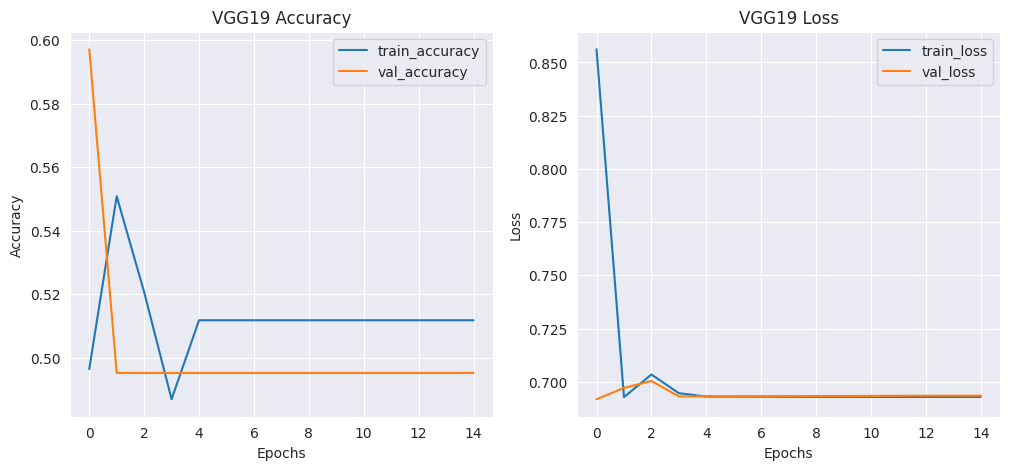

In [50]:
plot_history(vgg_history, 'VGG19')


In [51]:
vgg_eval = vgg_model.evaluate(valid_data)
print(f"VGG19 Validation Accuracy: {vgg_eval[1]:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.5022 - loss: 0.6932
VGG19 Validation Accuracy: 0.4953


In [52]:
import numpy as np
from sklearn.metrics import classification_report

def classification_report_for_model(model, valid_data):
    valid_data.reset()
    predictions = model.predict(valid_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = valid_data.classes
    print(classification_report(y_true, y_pred, target_names=list(valid_data.class_indices.keys())))
    
    
print("classification report for VGG19 model")
classification_report_for_model(vgg_model, valid_data)

classification report for VGG19 model
14/14 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step
              precision    recall  f1-score   support

    cataract       0.00      0.00      0.00       213
      normal       0.50      1.00      0.66       209

    accuracy                           0.50       422
   macro avg       0.25      0.50      0.33       422
weighted avg       0.25      0.50      0.33       422



/home/shelton/Documents/Isutc/ML/pratics/cataract_detection/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shelton/Documents/Isutc/ML/pratics/cataract_detection/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shelton/Documents/Isutc/ML/pratics/cataract_detection/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi